In [18]:
import os
import pickle
import logging

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats

import arviz as az
from numpyro.diagnostics import hpdi

from hbmep.config import Config
from hbmep.model.utils import Site as site

from hbmep_paper.utils import setup_logging
from core import DATA_PATH
from models import MixtureModel

plt.rcParams["svg.fonttype"] = "none"
logger = logging.getLogger(__name__)

POSTERIOR_DIR = "/home/vishu/repos/hbmep-paper/reports/tms/group-comparison"
BUILD_DIR = "/home/vishu/repos/hbmep-paper/reports/tms/group-comparison"
setup_logging(
    dir=BUILD_DIR,
    fname="comparison"
)


2024-01-24 10:32:51,011 - hbmep_paper.utils.utils - INFO - Logging to /home/vishu/repos/hbmep-paper/reports/tms/group-comparison/comparison.log


In [2]:
src = os.path.join(POSTERIOR_DIR, "inference.pkl")
with open(src, "rb") as g:
    model, mcmc, posterior_samples = pickle.load(g)


In [3]:
a_loc = posterior_samples["a_loc"]
a_loc.shape

(4000, 2, 3)

In [4]:
df = pd.read_csv(DATA_PATH)
df, encoder_dict = model.load(df=df)

subset = [(5, 1), (18, 0)]
ind = df[model.features].apply(tuple, axis=1).isin(subset)
df = df[ind].reset_index(drop=True).copy()

df.shape


2024-01-24 10:19:42,597 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/tms/group-comparison
2024-01-24 10:19:42,598 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/tms/group-comparison
2024-01-24 10:19:42,599 - hbmep.dataset.core - WARNING - Total non-positive observations: 0
2024-01-24 10:19:42,599 - hbmep.dataset.core - WARNING - Total missing observations: 0
2024-01-24 10:19:42,599 - hbmep.dataset.core - INFO - Processing data ...
2024-01-24 10:19:42,600 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


(164, 119)

In [5]:
encoder_dict[model.features[1]].inverse_transform([0, 1])


array(['SCI', 'Uninjured'], dtype=object)

In [6]:
a_loc = posterior_samples["a_loc"]
a_loc.shape


(4000, 2, 3)

In [7]:
((a_loc[:, 0, :] - a_loc[:, 1, :]) > 0).mean(axis=0)


array([0.92975, 0.90275, 0.95925])

In [8]:
response_colors = {
    0: (0.8157, 0.1098, 0.5451),
    1: (0.2055, 0., 0.4000),
    2: (0.3000, 0.3000, 0.3000)
}
prior_color = (.7, .7, .7)


In [9]:
_posterior_samples = posterior_samples.copy()
_posterior_samples[site.outlier_prob] = _posterior_samples[site.outlier_prob] * 0
prediction_df = model.make_prediction_dataset(df=df, num=5000)
posterior_predictive = model.predict(df=prediction_df, posterior_samples=_posterior_samples)


2024-01-24 10:19:59,686 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2024-01-24 10:20:47,538 - hbmep.utils.utils - INFO - func:predict took: 47.85 sec


In [10]:
a = posterior_samples[site.a]
a_map = a.mean(axis=0)

mu = posterior_predictive[site.mu]

obs = posterior_predictive[site.obs]
obs_hpdi = hpdi(obs, prob=.95)


2024-01-24 10:46:04,573 - __main__ - INFO - Saved figure to /home/vishu/repos/hbmep-paper/reports/tms/group-comparison/group_comparison.png


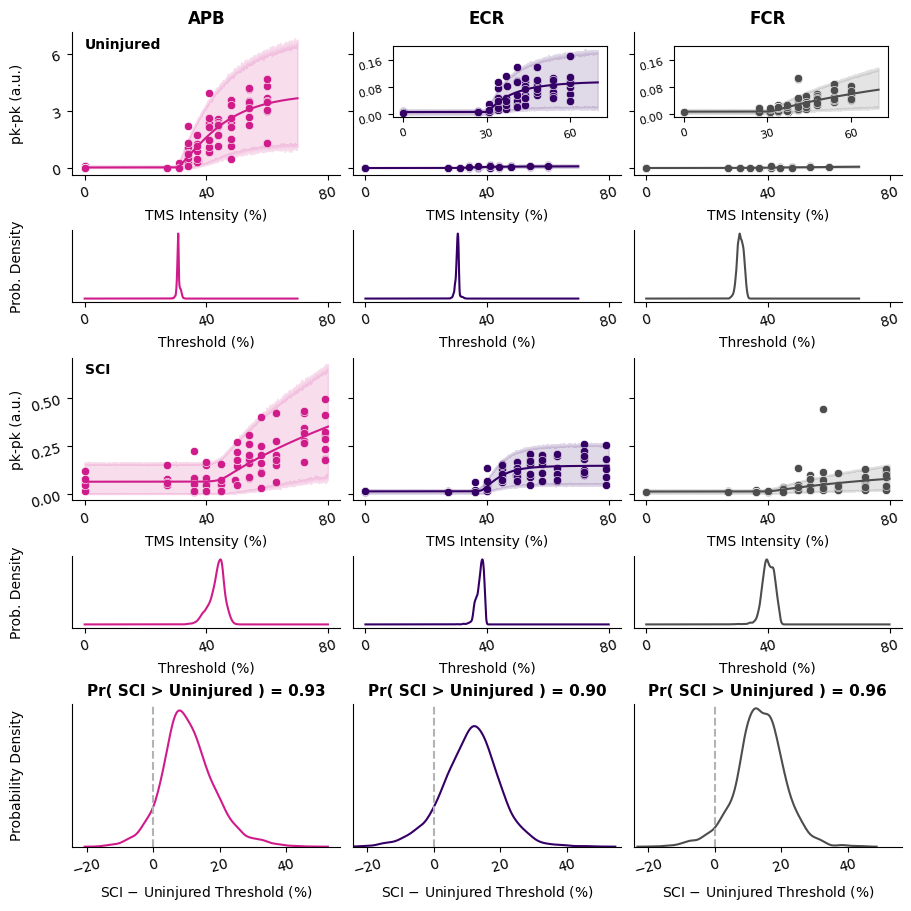

In [37]:
response = ["APB", "ECR", "FCR"]
axis_label_size = 10

""" Plot """
nrows, ncols = 5, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 1.8 * nrows), squeeze=False, height_ratios=[1, .5, 1, .5, 1], constrained_layout=True)

rec_ins = []

for muscle_ind in range(model.n_response):
    color = response_colors[muscle_ind]

    for c_counter, c in enumerate([(5, 1), (18, 0)]):
        ind = df[model.features].apply(tuple, axis=1).isin([c])
        temp_df = df[ind].reset_index(drop=True).copy()

        pred_ind = prediction_df[model.features].apply(tuple, axis=1).isin([c])
        temp_pred_df = prediction_df[pred_ind].reset_index(drop=True).copy()

        temp_obs = obs[:, pred_ind, muscle_ind]
        temp_mu = mu[:, pred_ind, muscle_ind]
        temp_obs_hpdi = obs_hpdi[:, pred_ind, muscle_ind]

        ax = axes[2 * c_counter, muscle_ind]
        sns.scatterplot(x=temp_df[model.intensity], y=temp_df[model.response[muscle_ind]], ax=ax, color=color)
        sns.lineplot(x=temp_pred_df[model.intensity], y=temp_mu.mean(axis=0), color=color, ax=ax)
        ax.fill_between(
            temp_pred_df[model.intensity],
            temp_obs_hpdi[0, :],
            temp_obs_hpdi[1, :],
            color=color,
            alpha=.15
        )
        ax.sharex(axes[0, 0])
        ax.sharey(axes[2 * c_counter, 0])

        if (c, muscle_ind) in [((5, 1), 1), ((5, 1), 2)]:
            ins = ax.inset_axes([0.15,0.4,0.8 ,0.5])
            rec_ins.append(ins)
            sns.scatterplot(x=temp_df[model.intensity], y=temp_df[model.response[muscle_ind]], ax=ins, color=color)
            sns.lineplot(x=temp_pred_df[model.intensity], y=temp_mu.mean(axis=0), color=color, ax=ins)
            ins.fill_between(
                temp_pred_df[model.intensity],
                temp_obs_hpdi[0, :],
                temp_obs_hpdi[1, :],
                color=color,
                alpha=.15
            )
            ins.set_xlabel("")
            ins.set_ylabel("")
            ins.xaxis.set_major_locator(plt.MaxNLocator(3))
            ins.yaxis.set_major_locator(plt.MaxNLocator(3))
            # ins.set_xlim(left=4, right=6)
            ins.tick_params(
                axis='both',
                which='both',
                left=True,
                bottom=True,
                right=False,
                top=False,
                labelleft=True,
                labelbottom=True,
                labelright=False,
                labeltop=False,
                labelrotation=15,
                labelsize=8
            )

        ax = axes[2 * c_counter + 1, muscle_ind]
        samples = a[:, *c, muscle_ind]
        # sns.kdeplot(a[:, *c, muscle_ind], ax=ax, color=color)

        kde = stats.gaussian_kde(samples)
        x_grid = temp_pred_df[model.intensity].unique()
        density = kde(x_grid)
        ax.plot(x_grid, density, color=color)

        ax.sharex(axes[0, 0])

    ax = axes[4, muscle_ind]
    samples = a_loc[:, 0, muscle_ind] - a_loc[:, 1, muscle_ind]
    sns.kdeplot(samples, ax=ax, color=color, label="Posterior")

    # kde = stats.gaussian_kde(samples)
    # # x_grid = prediction_df[model.intensity].unique()
    # x_grid = np.arange(-20, 40, .05)
    # density = kde(x_grid)
    # ax.plot(x_grid, density, color=color, label="Posterior")

    prob = (samples > 0).mean()
    ax.set_title(f"Pr( SCI > Uninjured ) = {prob:.2f}", fontweight="bold", size=11)
    ax.sharex(axes[4, 0])
    ax.sharey(axes[4, 0])
    ax.axvline(x=0, color=prior_color, linestyle="--")

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        sides = ['right', 'top']
        for side in sides:
            ax.spines[side].set_visible(False)
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15
        )
        ax.set_xlabel("")
        ax.set_ylabel("")

for muscle_ind in range(model.n_response):
    for c_counter, c in enumerate([(5, 1), (18, 0)]):
        ax = axes[2 * c_counter, muscle_ind]
        ax.set_xlabel("TMS Intensity (%)", size=axis_label_size)

        ax = axes[2 * c_counter + 1, muscle_ind]
        ax.set_xlabel("Threshold (%)", size=axis_label_size)
        ax.tick_params(
            axis='both',
            which='both',
            left=False,
            labelleft=False,
            labelrotation=15
        )

    ax = axes[4, muscle_ind]
    ax.set_xlabel("SCI $-$ Uninjured Threshold (%)", size=axis_label_size)
    ax.tick_params(
        axis='both',
        which='both',
        left=False,
        labelleft=False,
        labelrotation=15
    )

    ax = axes[0, muscle_ind]
    ax.set_title(response[muscle_ind], fontweight="bold")
    # ax.set_title(response[muscle_ind], fontweight="bold", color=response_colors[muscle_ind])

ax = axes[0, 0]
ax.tick_params(
    axis='both',
    which='both',
    labelleft=True,
    labelrotation=15
)
ax.set_ylabel("pk-pk (a.u.)", size=axis_label_size)
ax.set_xticks([0, 40, 80])
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.text(.001, 6.5, "Uninjured", size=10, ha="left", va="center", fontweight="bold")

ax = axes[1, 0]
ax.set_ylabel("Prob. Density", size=axis_label_size)

ax = axes[2, 0]
ax.set_ylabel("pk-pk (a.u.)", size=axis_label_size)
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.tick_params(
    axis='both',
    which='both',
    left=True,
    labelleft=True,
)
ax.text(.001, 0.65, "SCI", size=10, ha="left", va="center", fontweight="bold")

ax = axes[3, 0]
ax.set_ylabel("Prob. Density", size=axis_label_size)

ax = axes[4, 0]
ax.tick_params(
    axis='both',
    which='both',
    left=False,
    labelleft=False,
    labelbottom=True,
    labelrotation=15
)
ax.set_ylabel("Probability Density", size=axis_label_size)
ax.set_xticks([-20, 0, 20, 40])

rec_ins[1].sharex(rec_ins[0])
rec_ins[1].sharey(rec_ins[0])

fig.align_xlabels()
fig.align_ylabels()

dest = os.path.join(BUILD_DIR, "group_comparison.svg")
fig.savefig(dest, dpi=600)
dest = os.path.join(BUILD_DIR, "group_comparison.png")
fig.savefig(dest, dpi=600)
logger.info(f"Saved figure to {dest}")


2024-01-24 10:56:34,107 - __main__ - INFO - Saved figure to /home/vishu/repos/hbmep-paper/reports/tms/group-comparison/group_comparison_toolbox_grant.png


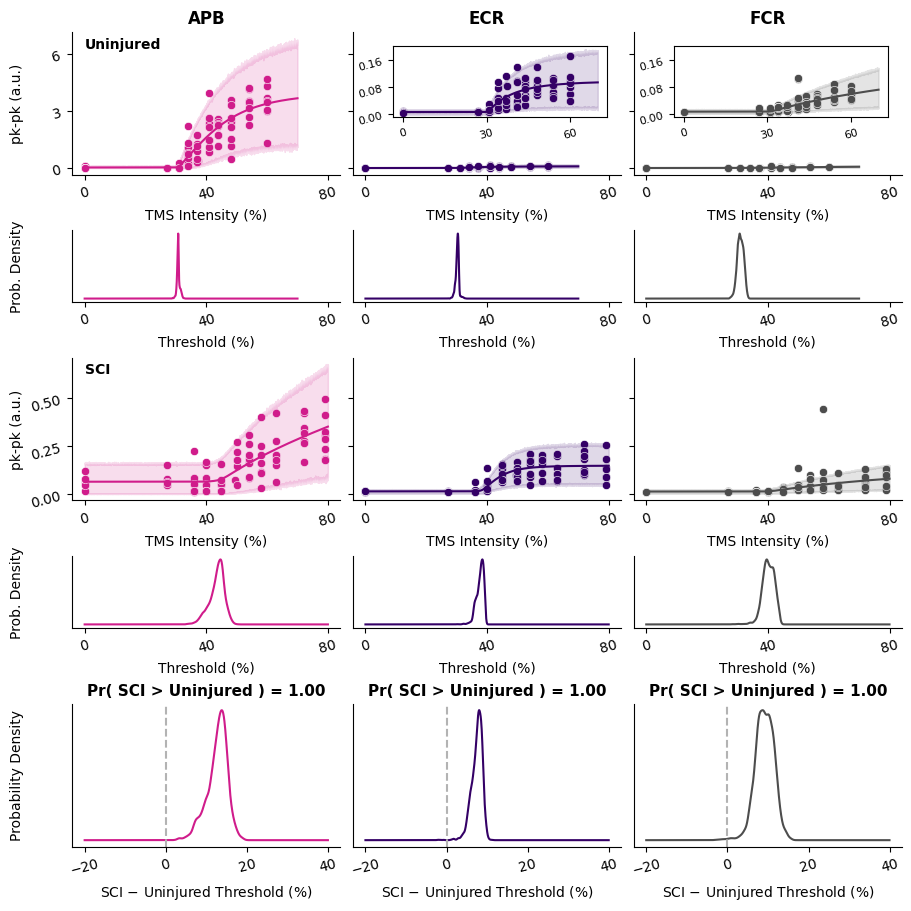

In [59]:
response = ["APB", "ECR", "FCR"]
axis_label_size = 10

""" Plot """
nrows, ncols = 5, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 1.8 * nrows), squeeze=False, height_ratios=[1, .5, 1, .5, 1], constrained_layout=True)

rec_ins = []

for muscle_ind in range(model.n_response):
    color = response_colors[muscle_ind]

    for c_counter, c in enumerate([(5, 1), (18, 0)]):
        ind = df[model.features].apply(tuple, axis=1).isin([c])
        temp_df = df[ind].reset_index(drop=True).copy()

        pred_ind = prediction_df[model.features].apply(tuple, axis=1).isin([c])
        temp_pred_df = prediction_df[pred_ind].reset_index(drop=True).copy()

        temp_obs = obs[:, pred_ind, muscle_ind]
        temp_mu = mu[:, pred_ind, muscle_ind]
        temp_obs_hpdi = obs_hpdi[:, pred_ind, muscle_ind]

        ax = axes[2 * c_counter, muscle_ind]
        sns.scatterplot(x=temp_df[model.intensity], y=temp_df[model.response[muscle_ind]], ax=ax, color=color)
        sns.lineplot(x=temp_pred_df[model.intensity], y=temp_mu.mean(axis=0), color=color, ax=ax)
        ax.fill_between(
            temp_pred_df[model.intensity],
            temp_obs_hpdi[0, :],
            temp_obs_hpdi[1, :],
            color=color,
            alpha=.15
        )
        ax.sharex(axes[0, 0])
        ax.sharey(axes[2 * c_counter, 0])

        if (c, muscle_ind) in [((5, 1), 1), ((5, 1), 2)]:
            ins = ax.inset_axes([0.15,0.4,0.8 ,0.5])
            rec_ins.append(ins)
            sns.scatterplot(x=temp_df[model.intensity], y=temp_df[model.response[muscle_ind]], ax=ins, color=color)
            sns.lineplot(x=temp_pred_df[model.intensity], y=temp_mu.mean(axis=0), color=color, ax=ins)
            ins.fill_between(
                temp_pred_df[model.intensity],
                temp_obs_hpdi[0, :],
                temp_obs_hpdi[1, :],
                color=color,
                alpha=.15
            )
            ins.set_xlabel("")
            ins.set_ylabel("")
            ins.xaxis.set_major_locator(plt.MaxNLocator(3))
            ins.yaxis.set_major_locator(plt.MaxNLocator(3))
            # ins.set_xlim(left=4, right=6)
            ins.tick_params(
                axis='both',
                which='both',
                left=True,
                bottom=True,
                right=False,
                top=False,
                labelleft=True,
                labelbottom=True,
                labelright=False,
                labeltop=False,
                labelrotation=15,
                labelsize=8
            )

        ax = axes[2 * c_counter + 1, muscle_ind]
        samples = a[:, *c, muscle_ind]
        # sns.kdeplot(a[:, *c, muscle_ind], ax=ax, color=color)

        kde = stats.gaussian_kde(samples)
        x_grid = temp_pred_df[model.intensity].unique()
        density = kde(x_grid)
        ax.plot(x_grid, density, color=color)

        ax.sharex(axes[0, 0])

    ax = axes[4, muscle_ind]
    c_1, c_2 = subset
    samples = a[:, *c_2, muscle_ind] - a[:, *c_1, muscle_ind]
    # sns.kdeplot(samples, ax=ax, color=color, label="Posterior")

    kde = stats.gaussian_kde(samples)
    x_grid = np.arange(-20, 40, .05)
    density = kde(x_grid)
    ax.plot(x_grid, density, color=color, label="Posterior")

    prob = (samples > 0).mean()
    ax.set_title(f"Pr( SCI > Uninjured ) = {prob:.2f}", fontweight="bold", size=11)
    ax.sharex(axes[4, 0])
    # ax.sharey(axes[4, 1])
    ax.axvline(x=0, color=prior_color, linestyle="--")

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        sides = ['right', 'top']
        for side in sides:
            ax.spines[side].set_visible(False)
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15
        )
        ax.set_xlabel("")
        ax.set_ylabel("")

for muscle_ind in range(model.n_response):
    for c_counter, c in enumerate([(5, 1), (18, 0)]):
        ax = axes[2 * c_counter, muscle_ind]
        ax.set_xlabel("TMS Intensity (%)", size=axis_label_size)

        ax = axes[2 * c_counter + 1, muscle_ind]
        ax.set_xlabel("Threshold (%)", size=axis_label_size)
        ax.tick_params(
            axis='both',
            which='both',
            left=False,
            labelleft=False,
            labelrotation=15
        )

    ax = axes[4, muscle_ind]
    ax.set_xlabel("SCI $-$ Uninjured Threshold (%)", size=axis_label_size)
    ax.tick_params(
        axis='both',
        which='both',
        left=False,
        labelleft=False,
        labelrotation=15
    )

    ax = axes[0, muscle_ind]
    ax.set_title(response[muscle_ind], fontweight="bold")
    # ax.set_title(response[muscle_ind], fontweight="bold", color=response_colors[muscle_ind])

ax = axes[0, 0]
ax.tick_params(
    axis='both',
    which='both',
    labelleft=True,
    labelrotation=15
)
ax.set_ylabel("pk-pk (a.u.)", size=axis_label_size)
ax.set_xticks([0, 40, 80])
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.text(.001, 6.5, "Uninjured", size=10, ha="left", va="center", fontweight="bold")

ax = axes[1, 0]
ax.set_ylabel("Prob. Density", size=axis_label_size)

ax = axes[2, 0]
ax.set_ylabel("pk-pk (a.u.)", size=axis_label_size)
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.tick_params(
    axis='both',
    which='both',
    left=True,
    labelleft=True,
)
ax.text(.001, 0.65, "SCI", size=10, ha="left", va="center", fontweight="bold")

ax = axes[3, 0]
ax.set_ylabel("Prob. Density", size=axis_label_size)

ax = axes[4, 0]
ax.tick_params(
    axis='both',
    which='both',
    left=False,
    labelleft=False,
    labelbottom=True,
    labelrotation=15
)
ax.set_ylabel("Probability Density", size=axis_label_size)
ax.set_xticks([-20, 0, 20, 40])

rec_ins[1].sharex(rec_ins[0])
rec_ins[1].sharey(rec_ins[0])

# ax = axes[4, 1]
# ax.set_ylim(bottom=-.008)

fig.align_xlabels()
fig.align_ylabels()

dest = os.path.join(BUILD_DIR, "group_comparison_toolbox_grant.svg")
fig.savefig(dest, dpi=600)

dest = os.path.join(BUILD_DIR, "group_comparison_toolbox_grant.png")
fig.savefig(dest, dpi=600)
logger.info(f"Saved figure to {dest}")
